## Adaptive Step Size Method

Our goal is to implement the adaptive step size forward Euler method with the explicit trapezoidal method embedded in it for estimating the error. More explanation is in the lecture notes PDF. Here is the algorithm.

<ul>
<li> Initialize $h$ to a small number (e.g 1/100th of the time span (t0 to tF) (Note 1/100th is chosen arbitrarily - you may want to start smaller)
<li> Initialize lists for y, t, and the step-sizes.
<li> While the final time in the list of time steps is $<$ tF
	<ul>
	<li> Compute YFE using step size $h$ with the forward Euler method (the beginning of the step is the last element of the time list and the last element of the y list)
	<li> Compute YET using step size $h$ with the explicit Trapezoidal method
	<li> Estimate the error (err) using the Euclidean distance between YET and YFE.
	<li> If err $\leq$ ETOL, then append the time step to the list of time steps, append YFE to the list of solutions, and append $h$ to the list of step sizes.
	<li> Determine the step size for the next step (assuming $err > 0$, else $h_{new} = h$)
		\begin{equation*}
		h_{new} = h \cdot \sqrt{0.9 \frac{ETOL}{err}}
		\end{equation*}
    <li> If $h_{new} > 2h$ then $h_{new} = 2*h$ (make sure h doesn't more than double).
	<li> Set $h$ to $h_{new}$. This will be used either for the next step (if err was small enough) or to retry the current step (but with adjusted size) again.
    </ul>
</ul>


In [69]:
import numpy as np
import scipy.integrate
import numpy.linalg
import matplotlib.pyplot as plt

def degradation_model( t, y, params ):
    y1 = y[0]
    y2 = y[1]
    dydt = np.zeros( (2,) )
    dydt[0] = -params[0] * y1
    dydt[1] = -params[1] * y2
    return dydt

In [70]:
def forwardEulerAdaptiveStepSize(f,t0,tFinal,y0,params,ETOL):
    """
                  Runge-Kutta Method of Order 1 (Forward Euler) embedded
                       in Runge-Kutta Method of Order 2 (Trapezoidal)
    Performs Forward Euler method of integration
    for O.D.E's, using an error estimate (assuming an embedded order 2 method is 
    the true solution) to control the step-size.
    [t,y,h] = forwardEulerAdaptiveStepSize(f,h,t0,tFinal,y0)
      f : function handle for f(t,y) = y'
          (where f has signature y = f(t,y,params) with
               t as a scalar
               y is a column vector with the same length as y0
               params is a vector with the parameters)
      t0     : initial time
      tFinal : final time
      y0     : initial conditions
      params : model parameters
      ETOL   : maximum error tolerated. The step size will be chosen to guarantee 
               that the estimated error is smaller than ETOL.
    Return values:
      t      : the entire series of time steps 
      y      : the series of values of y at each time step
               (has dimensions length(y0) by length(t))
      steps  : the set of step-sizes taken internally
      """
    if tFinal <= t0:
        disp(['Error - the final time is before the initial time']);
        return;
    t = [t0];
    steps = [];
    h = (tFinal-t0)/100;
    # start with y as a list of nparrays.
    y = [np.array(y0)]; # list of 1st order solutions
    while t[-1] < tFinal:
        Yi = y[-1];
        YFE = Yi + h * f(t[0],Yi,params);
        YET = Yi + h/2 * f(t[-1],Yi,params) + h/2 * f(t[-1]+h,YFE,params);
        err = numpy.linalg.norm(YET-YFE,2);
        if err <= ETOL:
            # The step size was small enough.  Record this
            # info and determine the next step size.
            t.append( t[-1] + h );
            steps.append( h );
            y.append( YFE )
        hnew = h * np.sqrt(0.9*ETOL/err);
        # Make sure h doesn't more than double
        if hnew >= 2*h:
            hnew = 2*h;
        h = hnew;


    t = np.array(t)
    y = np.array(y).T
    steps = np.array(steps)
    return (t,y,steps)


### Run and plot result from adaptive method.

Run both the adaptive forward Euler method on the degradation model with degradation rates (2,5) and initial conditions (1,1) with time beginning at 0 and ending at 4. Use an error control (EST) of 1e-4.

Then plot the true solution (solid lines) and the adaptive forward Euler's solution (dashed lines).

Then plot the difference over time between the true solution and adaptive forward Euler's solution (dashed lines).

Finally, plot the step size over time.

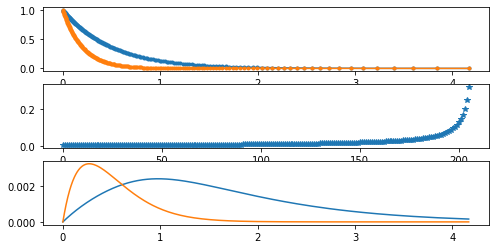

In [71]:
params = (2,5)
y0 = np.array([1,1])
(t,y,steps) = forwardEulerAdaptiveStepSize( degradation_model, 0, 4, y0, params, 1e-4)
tru_y1 = y0[0]*np.exp(-params[0]*t)
tru_y2 = y0[1]*np.exp(-params[1]*t)
tru_y = np.vstack( ( tru_y1, tru_y2) )
plt.figure( figsize = (8,4) )
plt.subplot(3,1,1)
plt.plot( t, y.T, '.-' );
plt.subplot( 3, 1, 2 )
plt.plot( steps, '*' );
plt.subplot( 3, 1, 3)
plt.plot( t, tru_y.T-y.T );

### Step Size vs Desired Estimated Error

Determine which time steps are chosen, given the value of ETOL. Also, compare the ETOL to the actual error.

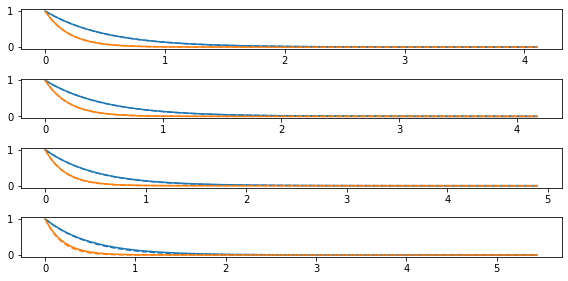

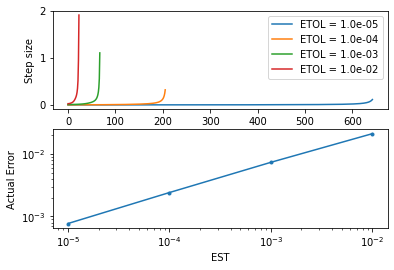

In [72]:
# range from smallest timestep that doesn't take way too long to run to largest time step with qualitatively correct answer.
ETOLs = np.array([1e-5,1e-4,1e-3,1e-2])
act_err = np.zeros( (ETOLs.size,) )
params = (2,5)
y0 = np.array((1,1))
t0 = 0
tF = 4
all_steps = []

plt.figure(figsize=(8,4))
for i in range(ETOLs.size):
    (t,y,steps) = forwardEulerAdaptiveStepSize( degradation_model, t0, tF, y0, params, ETOLs[i])
    all_steps.append( steps )
    sol = scipy.integrate.solve_ivp(fun=degradation_model, t_span=(t0, t[-1]), y0=y0,                 
                    method='LSODA', rtol=1e-8, atol=1e-8, t_eval=t, args=[params] )
    plt.subplot( ETOLs.size, 1, i+1 )
    plt.plot( t, sol.y.T )
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    plt.plot( t, y.T, '--')
    act_err[i] = np.mean(scipy.linalg.norm( sol.y-y, 2, axis=0) )
plt.tight_layout()
    
plt.figure()
plt.subplot( 2, 1, 1 )
legs = []
for i in range(len(all_steps)):
    plt.plot( all_steps[i] )
    legs.append( "ETOL = %0.1e" % ETOLs[i])
plt.legend( legs )
plt.ylabel('Step size')
plt.subplot( 2, 1, 2 )
plt.loglog( ETOLs, act_err, '.-' );
plt.xlabel( 'EST');
plt.ylabel( 'Actual Error');

## Bonus Code
### Examine step size changes over time

Do we take lots of rejected steps?

Examine each step size attempted. To do this, I have taken the code out of the function and added lists to keep even the rejected steps. Here, I use the degradation model.

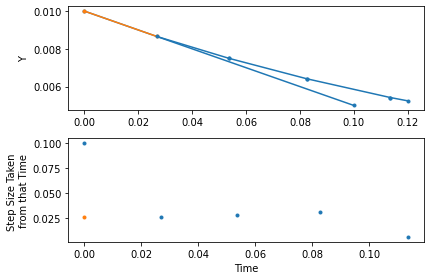

In [73]:
f = lambda t, y, params: -params[0]*y[0]
params = (5,)
y0 = np.array([.01,])
t0 = 0
tFinal = 0.12
h = 0.1
ETOL = 1e-4
t = [t0];
steps = [];
# start with y as a list of nparrays.
y = [np.array(y0)]; # list of 1st order solutions
attempted_t = [t0,[]]
attempted_y = [np.array(y0),[]]
while t[-1] < tFinal:
    Yi = y[-1];
    YFE = Yi + h * f(t[0],Yi,params);
    YET = Yi + h/2 * f(t[-1],Yi,params) + h/2 * f(t[-1]+h,YFE,params);
    attempted_t[-1].append( t[-1]+h )
    attempted_y[-1].append( YFE )
    err = numpy.linalg.norm(YET-YFE,2);
    hnew = h * np.sqrt(0.9*ETOL/err);
    # Make sure h doesn't more than double
    if hnew / h >= 2:
        hnew = 2*h;
    if err <= ETOL:
        # The step size was small enough.  Record this
        # info and determine the next step size.
        t.append( t[-1] + h );
        steps.append( h );
        y.append( YFE )
        h = hnew;
        if t[-1] + h >= tFinal:
            # If we are going to step out of bounds, then
            # restrict the size of the last step.
            h = tFinal - t[-1];
        attempted_t.append( [] )
        attempted_y.append( [] )
    else:
        h = hnew;

# The first step taken from any time point will be blue and the second orange.
plt.subplot( 2, 1, 1 )
for i in range(len(attempted_t)-1):
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    for j in range(len(attempted_t[i+1])):
        plt.plot( [t[i], attempted_t[i+1][j]], [y[i], attempted_y[i+1][j]], '.-' )
plt.ylabel( "Y")
plt.subplot( 2, 1, 2 )
for i in range(len(attempted_t)-1):
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    for j in range(len(attempted_t[i+1])):
        plt.plot( t[i], attempted_t[i+1][j]-t[i], '.' )
plt.xlabel( 'Time')
plt.ylabel( "Step Size Taken \nfrom that Time");
plt.tight_layout()

### Evaluate rejected steps for the Goodwin oscillator

Here I repeat the code from above, but use it on the Goodwin oscillator.

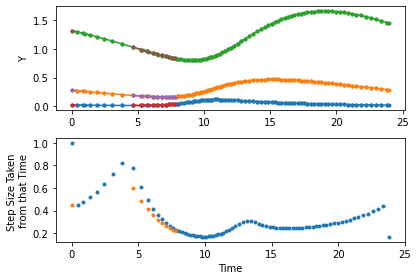

In [74]:
import numpy as np

def goodwin_oscillator( t, statevars, params ):
    X = statevars[0];
    Y = statevars[1];
    Z = statevars[2];
    alpha_1 = params[0]
    K = params[1]
    n = params[2]
    gamma_1 = params[3]
    alpha_2 = params[4]
    gamma_2 = params[5]
    alpha_3 = params[6]
    gamma_3 = params[7]
        
    dydt = np.zeros( (3,) )
    dydt[0] = alpha_1*K**n/(K**n+Z**n) - gamma_1*X
    dydt[1] = alpha_2*X - gamma_2*Y;
    dydt[2] = alpha_3*Y - gamma_3*Z;

    return dydt

f = goodwin_oscillator
alpha_1 = 1
K = 0.61
n = 11
gamma_1 = 0.15
alpha_2 = 1
gamma_2 = 0.15
alpha_3 = 1
gamma_3 = 0.25
params = (alpha_1,K,n,gamma_1,alpha_2,gamma_2,alpha_3,gamma_3)

y0 = np.array([0.02051344, 0.27934056, 1.31619671])

t0 = 0
tFinal = 24
h = 1
ETOL = 1e-3
t = [t0];
steps = [];
# start with y as a list of nparrays.
y = [np.array(y0)]; # list of 1st order solutions
attempted_t = [t0,[]]
attempted_y = [np.array(y0),[]]
while t[-1] < tFinal:
    Yi = y[-1];
    YFE = Yi + h * f(t[0],Yi,params);
    YET = Yi + h/2 * f(t[-1],Yi,params) + h/2 * f(t[-1]+h,YFE,params);
    attempted_t[-1].append( t[-1]+h )
    attempted_y[-1].append( YFE )
    err = numpy.linalg.norm(YET-YFE,2);
    hnew = h * np.sqrt(0.9*ETOL/err);
    # Make sure h doesn't more than double
    if hnew / h >= 2:
        hnew = 2*h;
    if err <= ETOL:
        # The step size was small enough.  Record this
        # info and determine the next step size.
        t.append( t[-1] + h );
        steps.append( h );
        y.append( YFE )
        h = hnew;
        if t[-1] + h >= tFinal:
            # If we are going to step out of bounds, then
            # restrict the size of the last step.
            h = tFinal - t[-1];
        attempted_t.append( [] )
        attempted_y.append( [] )
    else:
        h = hnew;

# The first step taken from any time point will be blue (X), orange (Y), or green (Z)
# The second step taken will be red(X), purple (Y), or brown (Z)
plt.subplot( 2, 1, 1 )
for i in range(len(attempted_t)-1):
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    for j in range(len(attempted_t[i+1])):
        plt.plot( [t[i], attempted_t[i+1][j]], [y[i], attempted_y[i+1][j]], '.-' )
plt.ylabel( "Y")
plt.subplot( 2, 1, 2 )
for i in range(len(attempted_t)-1):
    plt.gca().set_prop_cycle(None) # this resets the color cycle
    for j in range(len(attempted_t[i+1])):
        plt.plot( t[i], attempted_t[i+1][j]-t[i], '.' )
plt.xlabel( 'Time')
plt.ylabel( "Step Size Taken \nfrom that Time");
plt.tight_layout()